In [1]:
import pandas as pd
from tqdm import tqdm
import gensim
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# os.chdir(r"D://Proposal_Defense//Simulations")
# from Utils.Script_utils import get_data_splits, first_LSTM_training, get_data_splits_old_algo
from joblib import Parallel, delayed
import sys
from scipy.stats import norm

In [2]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 42

# 1. Set the `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set the `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set the `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# # 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")
# tf.config.set_visible_devices([], 'GPU')

from tqdm.notebook import tqdm
tf.random.set_seed(seed_value)
import multiprocessing
# for later versions: 
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
# from keras import backend as K
# session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
# K.set_session(sess)

No GPU found


In [3]:
import matplotlib.pyplot as plt

import pickle

In [4]:
model_cbow = gensim.models.word2vec.Word2Vec.load(r"..//Data_Generation//word2vec_sg")

In [5]:
# data["high_level_substr"].value_counts()

In [6]:
# data.head()

In [7]:
reps = 50

In [8]:
with open('..//Data_Generation//Data//train_valid_test_splits_50.pkl', 'rb') as f:
    catch = pickle.load(f)  

In [9]:
with open('..//Data_Generation//LSTM_Heavy_Dropout//heavy_dropout_first_lstm.pkl', 'rb') as f:
    first_lstm = pickle.load(f)  

In [10]:
with open('..//Data_Generation//Doc2Vec_ANN//doc2vec_ann.pkl', 'rb') as f:
    first_doc2vec_ann = pickle.load(f)  

    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_train_logits.pkl', 'rb') as f:
#     catch_train_logits = (pickle.load(f))    

# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_valid_logits.pkl', 'rb') as f:
#     catch_valid_logits = (pickle.load( f))      
    
# with open('..//Data_Generation//LSTM_Heavy_Dropout//Heavy_Data_test_logits.pkl', 'rb') as f:
#     catch_test_logits = (pickle.load( f))      
    

In [11]:
def ann(hidden = 10): 
    input_layer = tf.keras.layers.Input(shape = (X_train_word2vec.shape[1]))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(1)
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [12]:
h1, h2 = 16,16

In [13]:
X_train_word2vec = first_lstm[0][3].numpy()

In [14]:


ann_15 = ann(h1)


# In[35]:


# ann_15.summary()


# In[36]:



In [15]:
ann_15.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 25)]              0         
                                                                 
 dense (Dense)               (None, 16)                416       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________


In [16]:
X_train_word2vec = model_cbow.wv.vectors

In [17]:
ann_20 = ann(h2)



# ann_20.summary()



In [18]:
total_weights_1 = ann_15.count_params()

In [19]:
total_weights_2 = ann_20.count_params()

In [20]:
total_weights = total_weights_1 + total_weights_2 + 1 

In [21]:
total_weights

1267

In [22]:
## batch size
batch_size = 32

In [23]:
# var_weights = 0.08
# var_targets = 0.08

In [24]:
from scipy.stats import multivariate_normal as mvn

In [25]:
from scipy.stats import invgamma, norm

In [26]:
from tqdm.notebook import tqdm

In [27]:
threshold = 5

In [28]:
import random

In [29]:
lr = 0.1

In [30]:
import numpy as np

In [31]:
weights_ann_1 = ann_15.get_weights()
weights_ann_2 = ann_20.get_weights()

In [32]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1): 

    n_hidden_1 = len(weights_ann_1[0].ravel())

    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)

    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)



    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, 1)

    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + 1)].reshape(size_ens, 1, 1)



    final_output_1 = output_1 + output_layer_bias_1

    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2

    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, 1)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + 1)].reshape(size_ens, 1, 1)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]


    avg_weights = initial_ensembles[:, -1].reshape(-1,1)

    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    output_1_ravel = final_output_1.reshape(size_ens, final_output_1.shape[1]*final_output_1.shape[2])

    output_2_ravel = final_output_2.reshape(size_ens, final_output_2.shape[1]*final_output_2.shape[2])


    output_1_ravel = output_1_ravel

    output_2_ravel = output_2_ravel



    weights_1_add = np.zeros((size_ens, (total_weights_2 - total_weights_1)))



    weights_1 = np.hstack((weights_1, weights_1_add))
    


    stack_1 = np.hstack((output_1_ravel, weights_1, np.repeat(0, size_ens).reshape(-1,1), np.repeat(0, size_ens).reshape(-1,1)))



    
    stack_2 = np.hstack((output_2_ravel, weights_2, avg_weights, log_sigma_points_1))

    
    initial_aug_state = np.hstack((stack_1, stack_2)) 
    

    return initial_aug_state , output_1_ravel, output_2_ravel, log_sigma_points_1



In [33]:
import time

In [34]:
from scipy.stats import multivariate_normal as mvn

In [35]:
var_weights =2
# var_weights_vec = 4
# var_targets = 0.04
# var_weights = 2

In [36]:
from scipy.stats import multivariate_normal as mvn

In [37]:
reduction = 4
# reduction = 10

In [38]:
shape_needed = (total_weights + 2*batch_size*1 + 1 + (total_weights_2 - total_weights_1))//reduction

In [39]:
size_ens = shape_needed

In [40]:
size_ens = int(size_ens)

In [41]:
size_ens

433

In [42]:
# train_fudged_probs

In [43]:
import matplotlib.pyplot as plt

In [44]:
from scipy.special import expit

In [45]:
# catch1[0][0]

In [46]:
# catch_train_logits_second[0]

In [47]:
from datetime import datetime

In [48]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [49]:
from scipy.stats import gamma

In [50]:
# second_lstm[0]

In [51]:
# reduction = 8
# var_weights = 1

In [52]:
# cur_idx = 16
# np.log(catch_test_probs[cur_idx]/(1-catch_test_probs[cur_idx]))

In [53]:
# catch_preds_df

In [54]:
# ids = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] < 0.5]
# ids_more = [i for i in range(0, catch_test_probs[cur_idx].shape[0]) if catch_test_probs[cur_idx][i] > 0.5]

In [55]:
# ids_more

In [56]:
import plotly.express as px

In [57]:
import seaborn as sns

In [58]:
use_cores = multiprocessing.cpu_count()-1

In [59]:
use_cores = 15

In [60]:
# threshold = 200
# cutoff_threshold = 70

In [61]:
catch1 = first_lstm

In [62]:
catch2 = first_doc2vec_ann

In [63]:
from datetime import datetime

In [64]:
#     idx = 0
#     X_train_logits_lstm = np.vstack((catch1[idx][0], catch1[idx][1]))
#     X_train_logits_doc2vec_ann = np.vstack((catch2[idx][0], catch2[idx][1]))
    
#     X_train_probs_lstm = expit(X_train_logits_lstm)
#     X_train_probs_doc2vec_ann = expit(X_train_logits_doc2vec_ann)

In [65]:
# x = (X_train_probs_doc2vec_ann + X_train_probs_lstm)/2

In [66]:
# X_train_logits_doc2vec_ann

In [67]:
# X_train_logits_lstm

In [68]:
# plt.scatter(X_train_logits_doc2vec_ann, X_train_logits_lstm)

In [69]:
# np.log(x/(1-x))

In [70]:
# X_train_probs_lstm

In [71]:
# X_test_logits_lstm = catch1[idx][1]
# X_test_logits_doc2vec_ann = catch2[idx][1]

In [72]:
# X_test_logits_lstm

In [73]:
# X_test_logits_doc2vec_ann

In [74]:
# X_test_logits_doc2vec_ann

In [75]:
# X_test_logits_lstm

In [76]:
def rep_one_real_world(idx, inflation_factor = 0.2, cutoff = 100): 
#     from scipy.special import expit
    patience_smaller = 0
# patience_bigger = 0

#     best_train_acc = 0
#     best_valid_acc = 1000

#     best_valid_mae = 10
    
    best_train_mae = 100
    
    X_train_logits_lstm = np.vstack((catch1[idx][0], catch1[idx][1]))
    X_train_logits_doc2vec_ann = np.vstack((catch2[idx][0], catch2[idx][1]))
    
    X_train_probs_lstm = expit(X_train_logits_lstm)
    X_train_probs_doc2vec_ann = expit(X_train_logits_doc2vec_ann)
    
    averaged_probs_lstm_doc2vec_ann_train = (X_train_probs_lstm + X_train_probs_doc2vec_ann)/2
    X_train_logits = np.log(averaged_probs_lstm_doc2vec_ann_train/(1-averaged_probs_lstm_doc2vec_ann_train))
    
    # X_train_logits = averaged_probs_lstm_doc2vec_ann_train
    
    
    X_test_logits_lstm = catch1[idx][2]
    X_test_logits_doc2vec_ann = catch2[idx][2]
    
    X_test_probs_lstm = expit(X_test_logits_lstm)
    X_test_probs_doc2vec_ann = expit(X_test_logits_doc2vec_ann)
    
    averaged_probs_lstm_doc2vec_ann_test = (X_test_probs_lstm + X_test_probs_doc2vec_ann)/2
    X_test_logits = np.log(averaged_probs_lstm_doc2vec_ann_test/(1-averaged_probs_lstm_doc2vec_ann_test))
    # X_test_logits = averaged_probs_lstm_doc2vec_ann_test
    
    ## create training batch chunks
    train_idx = list(range(0, X_train_logits.shape[0]))
    batch_chunks = [train_idx[i:i+batch_size] for i in range(0,len(train_idx),batch_size)]

    ## generate some augmented variable for iteration 0
    initial_aug_state_mean = np.repeat(0, total_weights)
    initial_aug_state_mean = initial_aug_state_mean.reshape(-1,1)

    initial_aug_state_cov = var_weights*np.identity((total_weights))
    initial_ensembles = mvn(initial_aug_state_mean.reshape(initial_aug_state_mean.shape[0],), initial_aug_state_cov).rvs(size = size_ens)

    
    log_sigma_points_1 = (np.log(gamma(100, scale = 1/100).rvs(size_ens))).reshape(size_ens, 1)
    

#     y_train = catch_train_labels_second[idx]

#     y_valid = catch_valid_labels_second[idx]

#     y_test = catch_test_labels_second[idx]
    
    
    train_lstm = catch1[idx][3].numpy()
    valid_lstm = catch1[idx][4].numpy()
    # valid_word2vec = catch[idx][7].iloc[catch_valid_idxes[idx],:].reset_index(drop = True)
    test_lstm = catch1[idx][5].numpy()
 

    train_doc2vec = []
    for seq in catch[idx][0]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        train_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    train_doc2vec = np.array(train_doc2vec)
    
    valid_doc2vec = []
    for seq in catch[idx][1]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        valid_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    valid_doc2vec = np.array(valid_doc2vec)
    
    test_doc2vec = []
    for seq in catch[idx][2]:
        seq_txt = seq[0]
        seq_split = seq_txt.split(" ")
        test_doc2vec.append(doc2vec_dbow.infer_vector(seq_split))
    test_doc2vec = np.array(test_doc2vec)    
    
    
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm, test_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec, test_doc2vec))
    
    # train_valid_test_lstm = np.vstack((train_lstm, valid_lstm))
    # train_valid_test_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    
    
    train_valid_lstm = np.vstack((train_lstm, valid_lstm))
    train_valid_doc2vec = np.vstack((train_doc2vec, valid_doc2vec))    

    # best_width_train = 100
    
    # threshold_achieved = False
    # satisfactory = False
    # satisfactory_counter = 0
    
    
    best_coverage_train = 0
    
    start = datetime.now()
    
    for iter1 in range(0,500):

        for batch_idx in batch_chunks:

            batch_data = train_valid_lstm[batch_idx,:]
            batch_data1 = train_valid_doc2vec[batch_idx,:]
            # print(batch_data.shape)
            batch_targets = X_train_logits[batch_idx,:]
            # batch_targets = batch_targets.ravel().reshape(-1,1)

            column_mod_2_shape = total_weights_2 + batch_data.shape[0]*1 + 1 + 1
        
            H_t = np.hstack((np.identity(batch_targets.shape[0]), np.zeros((batch_targets.shape[0], column_mod_2_shape-batch_targets.shape[0]))))

            current_aug_state, column_mod_1, column_mod_2, log_sigma_points_1 = get_targets_with_weights(batch_data, batch_data1, initial_ensembles, log_sigma_points_1)
            
            var_targets_vec = np.log(1 + np.exp(log_sigma_points_1))
            
            var_targets_vec = var_targets_vec
            
            # current_aug_state_var = np.cov(current_aug_state.T) + inflation_factor*np.identity(current_aug_state.shape[1])
            
            current_aug_state_var = np.cov(current_aug_state.T) 
            
            G_t = np.array([1 , 1]).reshape(-1,1)
            
            scirpt_H_t = np.kron(G_t.T, H_t)
            
            temp1 = current_aug_state_var@scirpt_H_t.T
            
            temp2 = scirpt_H_t@current_aug_state_var@scirpt_H_t.T
        
            for ensemble_idx in range(0, current_aug_state.shape[0]):
                
                var_targets1 = var_targets_vec[ensemble_idx,:]
                
                R_t = var_targets1*np.identity(batch_targets.shape[0])
            
                measurement_error = mvn(np.repeat(0,batch_targets.shape[0]), var_targets1*np.identity(batch_targets.shape[0])).rvs(1).reshape(-1,1)
            
                target_current = batch_targets + measurement_error
                
                K_t = temp1@np.linalg.inv(temp2 + R_t)

                current_aug_state[ensemble_idx,:] = current_aug_state[ensemble_idx,:] +(K_t@(target_current -scirpt_H_t@current_aug_state[ensemble_idx,:].reshape(-1,1))).reshape(current_aug_state.shape[1],)
        

            weights_ann_1 = current_aug_state[:,batch_targets.shape[0]:(batch_targets.shape[0] + total_weights_1)]      

            weights_ann_2 = current_aug_state[:,-(total_weights_2+1):-2]    

            initial_ensembles = np.hstack((weights_ann_1, weights_ann_2, current_aug_state[:,-2].reshape(-1,1)))
            
            log_sigma_points_1 = current_aug_state[:,-1].reshape(-1,1)
               
            avg_betas = expit(current_aug_state[:,-2])
        
            complement = 1-avg_betas

            
            
            
            
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(train_valid_lstm, train_valid_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            
            initial_targets = initial_targets.reshape(size_ens, train_valid_lstm.shape[0],1)
            
            initial_targets_train = initial_targets
            
            
            
            
#             ind = (X_train_logits_true >= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[0,:,:]) & (X_train_logits_true <= np.percentile(initial_targets_train, axis = 0, q = (2.5, 97.5))[1,:,:])
        
            initial_targets_softmax = expit(initial_targets)
        
            initial_softmax_train = initial_targets_softmax
            
            initial_targets_train_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width_train = np.mean(width)
            
            # interim = np.vstack((catch_train_probs[idx] , catch_valid_probs[idx] ))
        
            interim = expit(X_train_logits)
            
            ind = (interim >= li) & (interim <= ui)
            
            coverage_train= np.mean(ind.ravel())  
            
            train_mae = np.mean(np.abs(interim.ravel() - initial_targets_train_mean.ravel()))
        
            current_aug_state1, column_mod_11, column_mod_21, log_sigma_points_1 = get_targets_with_weights(test_lstm, test_doc2vec, initial_ensembles, log_sigma_points_1)
            
            initial_targets = column_mod_11 + column_mod_21
            
            initial_targets = initial_targets.reshape(size_ens, test_lstm.shape[0],1)
            
            initial_targets_test = initial_targets
            
            initial_targets_softmax = expit(initial_targets)    
            
            initial_targets_test_mean = initial_targets_softmax.mean(0)
            
            li = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[0,:,:]
            
            ui = np.percentile(initial_targets_softmax, axis = 0, q = (2.5, 97.5))[1,:,:]
            
            width = ui - li
            
            avg_width = np.mean(width)
            
            catch_test_probs = expit(X_test_logits)
            
            ind_test = (catch_test_probs >= li) & (catch_test_probs <= ui)
               

                        
            coverage_test = np.mean(ind_test.ravel())    

            # initial_targets_test_mean = initial_targets_train.mean(0)
    
            
            
            test_mae = np.mean(np.abs(catch_test_probs.ravel() - initial_targets_test_mean.ravel()))
       
        # print(avg_width_train, best_train_width, coverage_train)
        
#         print("epoch "+ str(iter1))
#         print("patience "+ str(patience_smaller))
#         print("train mae is " + str(train_mae))
#         print("test mae is " + str(test_mae))
        
#         print("train coverage is "+ str(coverage_train))
#         print("train width is " + str(avg_width_train))        
#         print("test coverage is "+ str(coverage_test))
#         print("test width is " + str(avg_width))
#         print("lstm weight is " + str(np.mean(complement)))
        # print("threshold " + str(threshold_achieved))
              
    
        if (train_mae < best_train_mae) & (coverage_train > 0.95): 
#             cur_best_train_width = avg_width_train
#             cur_best_test_width = avg_width

#             cur_best_train_coverage = coverage_train
#             cur_best_test_coverage = coverage_test 
#             cur_best_lstm_weight = np.mean(complement)
            best_train_mae = train_mae
            best_test_mae = test_mae
            exit_iter_no_thresh = iter1
            best_test_preds = initial_targets_softmax
            patience_smaller = 0
            best_train_coverage = coverage_train
            best_test_coverage = coverage_test
            best_train_width = avg_width_train
            best_test_width = avg_width
            best_lstm_weight = np.mean(complement)
            # satisfactory = True
            
        else:
            patience_smaller+=1
            
        if patience_smaller > threshold:
            
            break
            
        if (patience_smaller > cutoff_threshold) & (train_mae < 0.05):
            
            break
            
            
    print(best_test_mae,best_test_coverage, best_test_width, best_lstm_weight, flush = True)
    end = datetime.now()
    total = (end-start)
    time_taken = total.seconds/60.0
    return best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight,   exit_iter_no_thresh, time_taken, best_test_preds
        
    # print("something went awry", flush = True)

In [77]:
threshold = 200

In [78]:
cutoff_threshold = 100

In [79]:
doc2vec_dbow = gensim.models.doc2vec.Doc2Vec.load(r"..//Data_Generation//doc2vec_dbow")

In [80]:
# best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight

In [81]:
# best_train_mae, best_test_mae, best_train_coverage, best_train_width, best_test_coverage, best_test_width, best_lstm_weight,   exit_iter_no_thresh, time_taken, best_test_preds = rep_one_real_world(9)

In [82]:
catch_coverages = Parallel(n_jobs=15, verbose = 10, backend = "loky")(delayed(rep_one_real_world)(i) for i in range(reps))

[Parallel(n_jobs=15)]: Using backend LokyBackend with 15 concurrent workers.


0.06225683142392339 1.0 0.29009730741339945 0.42439683682091867
0.043968528941625964 1.0 0.2425281471838671 0.4697386304478611


[Parallel(n_jobs=15)]: Done   2 tasks      | elapsed:  2.4min


0.04328598927193204 1.0 0.2642319419839311 0.5484016616580671
0.02920918298347393 1.0 0.21066727456710507 0.46955820156702294
0.028027743651716674 1.0 0.2686463609401283 0.5346350101702769
0.07605539026552399 0.75 0.17351970183734988 0.5113313794892189
0.06888776827666089 0.875 0.2212972375403859 0.4984762435759533
0.03966930306188366 1.0 0.14327532294279127 0.5105310780624026
0.048778420807501756 1.0 0.1937576424429967 0.4970142926369812
0.033961630432112394 0.875 0.13319146077416422 0.504670189735042
0.07795832545678492 0.625 0.16176040055408702 0.48361321736711926


[Parallel(n_jobs=15)]: Done  11 tasks      | elapsed:  2.9min


0.04805096378726579 0.75 0.16128417461176403 0.5127348475190334
0.060777796816049216 0.875 0.16777682837524213 0.5113105216852141
0.04427467753976315 0.875 0.2042449450209345 0.5081377287454055
0.04726450141928033 0.875 0.12466255197406043 0.5007463720838475
0.07163090226264775 1.0 0.3964080482105743 0.4162373972642539
0.03589936971370714 1.0 0.22905085763705174 0.43974110899599983
0.0757195865309897 0.875 0.15631362959410586 0.4954576248053942
0.10852013481585032 0.625 0.24176426471113444 0.5119238960237819
0.05266689404726564 0.75 0.1646602834867838 0.5123172511690535


[Parallel(n_jobs=15)]: Done  20 tasks      | elapsed:  5.1min


0.08592371730099392 0.625 0.1576538446181067 0.5000117076158752
0.08290592785144453 1.0 0.32329655646352196 0.46175217674360336
0.04840525479442105 0.875 0.2264314518966054 0.5096462632184711
0.09668036578948118 0.75 0.2639955942395736 0.5098579865290959
0.04582119024526676 1.0 0.2554830524736061 0.5350529180989578
0.028698949096775325 1.0 0.22794731232575874 0.48259062090510196
0.0523911153464537 1.0 0.25675929624352045 0.5056566039704852


[Parallel(n_jobs=15)]: Done  27 out of  50 | elapsed:  5.6min remaining:  4.8min


0.019564958953834886 1.0 0.2853470071352604 0.5034790252520293
0.0999430841012259 0.625 0.14521052326779224 0.49960086931285713
0.07031768405420305 1.0 0.44475642070942983 0.4560416496982906
0.0550891435255534 1.0 0.23571970257288033 0.5472131509455653
0.06340156314096441 0.5 0.13103442395074819 0.5012774179055863
0.028323835698070954 1.0 0.15261284633051517 0.49491752296920627


[Parallel(n_jobs=15)]: Done  33 out of  50 | elapsed:  7.4min remaining:  3.8min


0.04352857570605005 1.0 0.5032830673579134 0.41768843776306963
0.03607409985536611 1.0 0.290661515014341 0.449327699166091
0.06083474018567569 0.875 0.22981591669333457 0.5260397786713645
0.0900771380314023 0.75 0.1139996907060178 0.4458240932597391
0.03325886497345168 1.0 0.19604385024326254 0.5674351249756311
0.04730523543167889 0.625 0.10697858981234722 0.4993781873197203


[Parallel(n_jobs=15)]: Done  39 out of  50 | elapsed:  7.7min remaining:  2.2min


0.0624616106585133 0.875 0.2361448443606859 0.4706811691346452
0.0833755214211947 1.0 0.5281356556267185 0.6025967912204876
0.07555263399410192 0.625 0.16590410398204986 0.4929668470620174
0.09968474765718302 0.75 0.27215073286841385 0.45077364953784094
0.09162472549457878 0.625 0.13541608372192504 0.5025072480656729
0.07556837525590665 0.75 0.195702354910498 0.4931292213926705


[Parallel(n_jobs=15)]: Done  45 out of  50 | elapsed:  9.3min remaining:  1.0min


0.08190985852964763 0.75 0.2408532953108502 0.48791092960249566
0.07325459825289835 0.875 0.24797931518216976 0.5011098802735655
0.0970137297273144 0.625 0.1884566769157084 0.49061840138831636
0.09196962141649782 0.625 0.1686921029438448 0.4940964450978885
0.059871008676501865 0.875 0.17062672282136965 0.5112852225162957


[Parallel(n_jobs=15)]: Done  50 out of  50 | elapsed: 10.0min finished


In [83]:
# catch_coverages

In [84]:
check = pd.DataFrame(catch_coverages).iloc[:,:-1]

In [85]:
# check

In [86]:
# check

In [87]:
# check.columns = ["train_mae", "test_mae", "avg_ci_width_train", "avg_ci_width_test", "avg_lstm_weight", "exit_iter", "exit_status"]

In [88]:
check

,0,1,2,3,4,5,6,7,8
0,0.056179,0.062257,0.954545,0.240972,1.000,0.290097,0.424397,17,2.233333
1,0.028420,0.077958,0.954545,0.161588,0.625,0.161760,0.483613,44,2.766667
2,0.023982,0.047265,0.954545,0.103378,0.875,0.124663,0.500746,67,3.216667
3,0.037060,0.029209,0.969697,0.189522,1.000,0.210667,0.469558,28,2.416667
4,0.062961,0.068888,0.954545,0.262720,0.875,0.221297,0.498476,32,2.500000
5,0.033898,0.033962,0.954545,0.139706,0.875,0.133191,0.504670,45,2.733333
6,0.021125,0.060778,0.969697,0.125931,0.875,0.167777,0.511311,50,2.866667
7,0.030896,0.044275,0.984848,0.194055,0.875,0.204245,0.508138,51,2.883333
8,0.039510,0.048778,0.954545,0.184189,1.000,0.193758,0.497014,42,2.716667
9,0.035785,0.076055,0.969697,0.135239,0.750,0.173520,0.511331,31,2.466667


In [89]:
check.columns = ["train_mae", "test_mae", "train_coverage", "train_width", "test_coverage", "test_width", "lstm_weight" ,"exit_iter", "time_taken"]

In [90]:
check.mean()

train_mae          0.039630
test_mae           0.061554
train_coverage     0.966364
train_width        0.197740
test_coverage      0.855000
test_width         0.224925
lstm_weight        0.495429
exit_iter         35.540000
time_taken         2.541333
dtype: float64

In [91]:
check_mean = check.mean().reset_index()

In [92]:
check_mean.to_csv("Real_World_mean_metrics_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) +  ".csv", index = False)

In [93]:
check.std()

train_mae          0.010933
test_mae           0.022932
train_coverage     0.015394
train_width        0.065029
test_coverage      0.152279
test_width         0.090428
lstm_weight        0.035326
exit_iter         21.567370
time_taken         0.421142
dtype: float64

In [94]:
check_std = check.std().reset_index()

In [95]:
check_std.to_csv("Real_World_std_dev_metrics_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens)+  ".csv", index = False)

In [96]:
check.std()/reps

train_mae         0.000219
test_mae          0.000459
train_coverage    0.000308
train_width       0.001301
test_coverage     0.003046
test_width        0.001809
lstm_weight       0.000707
exit_iter         0.431347
time_taken        0.008423
dtype: float64

In [97]:
# with open("Real_World_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'rb') as f:
#     catch_coverages = pickle.load(f)  

In [98]:
# catch_coverages[0][-1].mean(0)

In [99]:
# expit(catch1[0][2])

In [100]:
true_preds = []
enkf_preds = []
for i in range(0,reps):
    all_preds = catch_coverages[i][-1]
    all_preds = all_preds.mean(0)
    catch_test_probs = (expit(catch1[i][2]) + expit(catch2[i][2]))/2
    true_probs = catch_test_probs.ravel().tolist()
    true_preds.append(true_probs)
    enkf_preds.append(all_preds.ravel().tolist())
    # plt.scatter(true_probs, all_preds.ravel().tolist())
    # plt.show()

In [101]:
true_preds = [inner for item in true_preds for inner in item]

In [102]:
enkf_preds = [inner for item in enkf_preds for inner in item]

In [103]:
# len(true_preds)

In [104]:
np.mean(np.abs(np.array(true_preds)-np.array(enkf_preds)))

0.06155391626360303

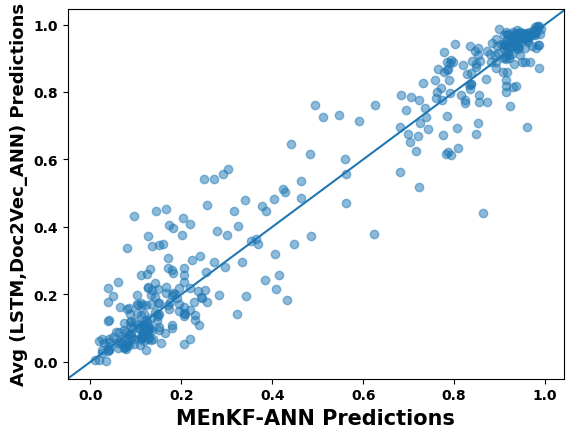

In [105]:
plt.scatter(enkf_preds,true_preds, alpha=0.5)
plt.xlabel("MEnKF-ANN Predictions", fontsize = 15, fontweight = "bold")
plt.ylabel("Avg (LSTM,Doc2Vec_ANN) Predictions", fontsize = 13, fontweight = "bold")
plt.xticks(fontsize = 10, fontweight = "bold")
plt.yticks(fontsize = 10, fontweight = "bold")
plt.axline((0, 0), slope=1)
plt.show()

In [106]:
with open("Real_World_ANN_LSTM_EnKF_LSTM_Doc2Vec_" + "var_weights_" + str(var_weights) + "_num_ens_" + str(size_ens) + ".pkl", 'wb') as f:
    first_lstm = pickle.dump(catch_coverages, f)  

In [107]:
# check